## Setup and imports

In [2]:
print('go')
import optim_esm_tools as oet
%run ../amoc_collapse_scripts/imports.py
from amoc_collapse_scripts import helper_scripts, manual_msft, path_setup

go


In [3]:
def gausian_filter(y, n=100, mu=7.5):
    b = gaussian(n, mu)
    gauss = scipy.ndimage.convolve1d(y, b / b.sum())
    return gauss


smoother = gausian_filter

In [4]:
base = path_setup.AMOC_STRENGTH_WORKING_DIR
paper_figure_path = os.path.join(base, 'paper_v2024.09.05_paper')
os.makedirs(base, exist_ok=True)
os.makedirs(paper_figure_path, exist_ok=True)

In [5]:
oet.utils.setup_plt()
oet.analyze.combine_variables.change_plt_table_height(1.5)

Change default plt.table row height


In [6]:
ds_ht_rapid_full = oet.load_glob(path_setup.RAPID_OHT)
ds_rapid_vert_full = oet.load_glob(path_setup.RAPID_AMOC)
t0 = oet.analyze.xarray_tools._native_date_fmt(ds_rapid_vert_full['time'], (2005, 1, 1))
t1 = oet.analyze.xarray_tools._native_date_fmt(
    ds_rapid_vert_full['time'], (2021, 12, 31, 23, 59, 59)
)
ds_rapid = ds_rapid_vert_full.sel(time=slice(t0, t1))
t0 = oet.analyze.xarray_tools._native_date_fmt(ds_ht_rapid_full['time'], (2005, 1, 1))
t1 = oet.analyze.xarray_tools._native_date_fmt(
    ds_ht_rapid_full['time'], (2019, 12, 31, 23, 59, 59)
)
ds_ht_rapid = ds_ht_rapid_full.sel(time=slice(t0, t1))


ds_transport = oet.load_glob(path_setup.OHT_TRANSPORT_CMIP6)

## Looping over all available data

In [7]:
heads = sorted(
    glob.glob(f'{path_setup.STEAMFUNCTION_BASE}/CMIP6/ScenarioMIP/*/*/*/*/*/msft*z/*/*')
)
len(heads)

1209

In [8]:
work_dir = os.path.join(
    base,
    'stats_v24.09.03.csv',
)
os.makedirs(work_dir, exist_ok=True)
p_info = os.path.join(work_dir, 'infos_v24.09.03.csv')
if os.path.exists(p_info):
    infos = pd.read_csv(p_info)
    infos = [a.to_dict() for _, a in infos.iterrows()]
else:
    infos = []
p_doc = os.path.join(work_dir, 'docs_v24.09.03.csv')
if os.path.exists(p_doc):
    docs = pd.read_csv(p_doc)
    docs = [a.to_dict() for _, a in docs.iterrows()]
else:
    docs = []

In [9]:
head = f'{path_setup.STEAMFUNCTION_BASE}/CMIP6/ScenarioMIP'
# There are a few files that cannot be processed correctly
bad = [
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp126/r1i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp126/r3i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp245/r1i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp245/r3i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp370/r1i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp370/r3i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp585/r1i1p1f1/Omon/msftmz/gn/v20201230',
    '/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/CAS/CAS-ESM2-0/ssp585/r3i1p1f1/Omon/msftmz/gn/v20201230',
]
to_fix = []

In [10]:
def read_from_h(h, need_pi=False):
    target = os.path.join(h, 'merged.nc')
    paths = manual_msft.find_paths(target, need_pi=need_pi)

    ds2, ds2_pi = manual_msft.get_dss_cached(paths, head, base)
    return ds2, ds2_pi

In [11]:
for h in oet.utils.tqdm(heads):
    if h in to_fix or h in bad or any(h == d['h'] for d in infos):
        continue

    target = os.path.join(h, 'merged.nc')
    if not os.path.exists(target):
        files = sorted(
            [f for f in glob.glob(os.path.join(h, '*.nc')) if 'merged.nc' not in f]
        )
        manual_msft.build_ds(files, target)
    try:
        try:
            paths = manual_msft.find_paths(target)
        except ValueError:
            paths = manual_msft.find_paths(target, need_pi=False)
    except ValueError as e:
        #         raise
        print(f'find {e} for {h}')
        infos.append(dict(h=h))
        docs.append(dict(h=h))
        pd.DataFrame(infos).to_csv(p_info, index=None)
        pd.DataFrame(docs).to_csv(p_doc, index=None)
        bad += [h]
        continue

    try:
        ds2, ds2_pi = manual_msft.get_dss_cached(paths, head, base)
        ds2_pi_shift = manual_msft.shift_to_start(ds2_pi, ds2, offset=50)
    except ValueError as e:
        bad += [h]
        print(f'build {e} for {h}')
        raise
    #         continue

    doc = manual_msft.tabulated_plot(ds2, ds2_pi_shift)
    name = ' '.join(target.replace(head, '').split(os.sep)[:-1])
    plt.suptitle(name, y=1.1)

    oet.utils.save_fig(
        save_in=os.path.join(base, 'figures_v4'),
        file_types=('png',),
        sub_dir='',
        name=name.replace(' ', '_') + '_v4',
    )
    oet.plotting.plot._show(len(docs) > 0.90 * (len(heads) - len(bad)) * len(doc))

    #     info={k: manual_msft.crit_E(**d) for k, d in doc.items()}
    info['last_year'] = int(ds2['time'].values[-1])

    info['h'] = h
    for b, row in doc.items():
        docs.append(dict(**row, h=h, basin=b))
    infos += [info]

    pd.DataFrame(infos).to_csv(p_info, index=None)
    pd.DataFrame(docs).to_csv(p_doc, index=None)

  0%|          | 0/1209 [00:00<?, ?it/s]

In [12]:
work_docs = docs.copy()

In [13]:
for i, d in enumerate(oet.utils.tqdm(work_docs.copy())):
    p_split = d['h'].split(os.sep)
    e = dict(
        source_id=p_split[path_setup.SOURCE_ID_INDEX],
        ssp=p_split[path_setup.SCENARIO_INDEX],
        variant_label=p_split[path_setup.VARIANT_LABEL_INDEX],
        variable_id=p_split[path_setup.VARIABLE_ID_INDEX],
        grid_id=p_split[path_setup.GRID_ID_INDEX],
        version=p_split[path_setup.VERSION_INDEX],
    )
    work_docs[i].update(e)
    if 'last_year' not in d:
        work_docs[i].update(
            dict(last_year=int(oet.load_glob(d['h'] + '/merged.nc')['time'].values[-1]))
        )
pd.DataFrame(docs).to_csv(p_doc, index=None)

  0%|          | 0/5415 [00:00<?, ?it/s]

### Some models have more than one dataset available for a given variant label (e.g. multiple versions of grids, make sure to only take one)

In [14]:
keep_one_per_source_per_ssp = []
for ssp in np.unique([w["ssp"] for w in work_docs]):
    for source_id in oet.utils.tqdm(
        np.unique([w["source_id"] for w in work_docs]), desc=ssp
    ):
        for variant_label in np.unique(
            [
                w["variant_label"]
                for w in work_docs
                if (w["source_id"] == source_id and w["ssp"] == ssp)
            ]
        ):

            matches = [
                w
                for w in work_docs
                if all(
                    w[k] == globals().get(k, 1)
                    for k in "ssp variant_label source_id".split()
                )
            ]
            versions = [os.path.split(w["h"])[1] for w in matches]
            variables = [w['variable_id'] for w in matches]
            if len(set(versions)) > 1:
                last_version = np.unique(versions)[1]
                print(
                    f"keep {last_version} of {set(versions)} for {source_id} {ssp} {variant_label}"
                )
                keep_one_per_source_per_ssp += [
                    w for w, v in zip(matches, versions) if v == last_version
                ]
            elif len(set(variables)) > 1:
                keep_var = np.unique(variables)[0]
                print(
                    f"keep {keep_var} of {set(variables)} for {source_id} {ssp} {variant_label}"
                )
                keep_one_per_source_per_ssp += [
                    w for w, v in zip(matches, variables) if v == keep_var
                ]
            elif len(matches) > len(set(w['basin'] for w in matches)):
                raise ValueError(matches)
            else:
                keep_one_per_source_per_ssp += matches
print(f"keep {len(keep_one_per_source_per_ssp)} of {len(work_docs)}")
work_docs = keep_one_per_source_per_ssp.copy()
del keep_one_per_source_per_ssp

ssp119:   0%|          | 0/40 [00:00<?, ?it/s]

keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp119 r1i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp119 r2i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp119 r3i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp119 r4i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp119 r5i1p1f1


ssp126:   0%|          | 0/40 [00:00<?, ?it/s]

keep v20210322 of {'v20200519', 'v20210322'} for ACCESS-ESM1-5 ssp126 r2i1p1f1
keep v20210318 of {'v20191201', 'v20210318'} for ACCESS-ESM1-5 ssp126 r3i1p1f1
keep v20210318 of {'v20210318', 'v20200908'} for ACCESS-ESM1-5 ssp126 r8i1p1f1
keep v20210318 of {'v20210318', 'v20200908'} for ACCESS-ESM1-5 ssp126 r9i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp126 r1i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp126 r2i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp126 r3i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp126 r4i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp126 r5i1p1f1


ssp245:   0%|          | 0/40 [00:00<?, ?it/s]

keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r10i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r1i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r2i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r3i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r3i1p3f1
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r4i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r4i1p3f1
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r5i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r5i1p3f1
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r6i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r7i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r8i1p1f2
keep v20240606 of {'v20200115', 'v20240606'} for GISS-E2-1-G ssp245 r9i1p1f

ssp370:   0%|          | 0/40 [00:00<?, ?it/s]

keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp370 r1i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp370 r2i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp370 r3i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp370 r4i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp370 r5i1p1f1


ssp585:   0%|          | 0/40 [00:00<?, ?it/s]

keep v20210318 of {'v20200519', 'v20210318'} for ACCESS-ESM1-5 ssp585 r2i1p1f1
keep v20210318 of {'v20191203', 'v20210318'} for ACCESS-ESM1-5 ssp585 r3i1p1f1
keep v20240820 of {'v20240820', 'v20190429'} for CanESM5 ssp585 r1i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r1i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r1i2p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r2i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r3i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r4i1p1f1
keep msftmz of {'msftmz', 'msftyz'} for MRI-ESM2-0 ssp585 r5i1p1f1
keep 5239 of 5415


## Organize all data in a table `df_info`

In [15]:
df_info = pd.DataFrame([i for i in work_docs if 'p_dip' in i])

In [16]:
df_info['_r'] = [int(a.split('i')[0][1:]) for a in df_info['variant_label'].values]
df_info['_y'] = -df_info['last_year']
df_info = df_info.sort_values(['source_id', 'ssp', '_y', '_r'])

In [17]:
_header = ['source_id', 'last_year', 'variant_label', 'variable_id', 'ssp']

In [18]:
df_info[
    (df_info.last_year > 2100)
    & (df_info.ssp == 'ssp126')
    & (df_info.basin == 'atlantic_max')
][_header]

,source_id,last_year,variant_label,variable_id,ssp
270,ACCESS-CM2,2300,r1i1p1f1,msftmz,ssp126
384,ACCESS-ESM1-5,2300,r1i1p1f1,msftmz,ssp126
450,ACCESS-ESM1-5,2300,r2i1p1f1,msftmz,ssp126
516,ACCESS-ESM1-5,2300,r3i1p1f1,msftmz,ssp126
528,ACCESS-ESM1-5,2300,r4i1p1f1,msftmz,ssp126
534,ACCESS-ESM1-5,2300,r5i1p1f1,msftmz,ssp126
540,ACCESS-ESM1-5,2300,r6i1p1f1,msftmz,ssp126
546,ACCESS-ESM1-5,2300,r7i1p1f1,msftmz,ssp126
552,ACCESS-ESM1-5,2300,r8i1p1f1,msftmz,ssp126
558,ACCESS-ESM1-5,2300,r9i1p1f1,msftmz,ssp126


### Smoothing functions

In [19]:
def rm_smooth(a, rm):
    if rm == 'smooth':
        return smoother(a)
    return helper_scripts.running_mean(a, rm)


def read_rmx_from_year(h, year=2095, rm=10):
    if isinstance(year, slice):
        year = year.start, year.stop
    return _read_rmx_from_year(h, year, rm)


@lru_cache(maxsize=20_000)
def _read_rmx_from_year(h, year=2095, rm=10):
    da = read_rmx_from_h(h, rm)
    if isinstance(year, tuple):
        return float(da.sel(time=slice(year[0], year[1])).mean('time'))
    return float(
        da.sel(
            time=year,
        )
    )


@lru_cache(maxsize=20_000)
def read_rmx_from_h(h, rm):
    ds2, _ = read_from_h(h)
    manual_msft.set_time_int(ds2)
    if rm == 1:
        return ds2['atlantic_max_fix']
    key = f'atlantic_max_fix_run_mean_{rm}'
    if key not in ds2:
        ds2[key] = xr.DataArray(
            rm_smooth(ds2['atlantic_max_fix'].values, rm), dims='time'
        )
    return ds2[key]


def read_except_rmx_from_h(h, y, rm='smooth'):
    try:
        return read_rmx_from_year(h, y, 'smooth')
    except (KeyError, ValueError):
        return np.nan

In [20]:
sc_dict = dict(ssp126='H_126', ssp245='H_245', ssp585='H_585')
sc_dict_inv = {v: k for k, v in sc_dict.items()}


def _get_ts_from_jenny(member, scenario):
    da_sel = ds_transport.sel(members=member)

    a = np.concatenate(
        [da_sel['H_hist'].values, da_sel[sc_dict.get(scenario, scenario)].values[10:]]
    )
    na = np.isnan(a)
    da = xr.DataArray(a[~na], dims='time')
    da['time'] = np.arange(1850, 2501)[~na]
    da['ssp'] = sc_dict_inv.get(scenario, scenario)
    return da


def get_oht_if_available(*a, last_year=2100):
    da = _get_ts_from_jenny(*a)
    if np.sum(np.isnan(da.values)) > 0:
        return
    if da.time.values[0] == 1850 and da.time.values[-1] >= last_year:
        return da

### Select passing data

In [21]:
df_info['pass'] = [
    (
        (
            (read_except_rmx_from_h(row.h, slice(2090, 2100)) < 8.6)
            | (read_except_rmx_from_h(row.h, slice(2290, 2300)) < 10)
        )
        & (row.last_year > 2100)
        & (row.basin == 'atlantic_max')
    )
    for _, row in oet.utils.tqdm(list(df_info.iterrows()))
]

  0%|          | 0/5239 [00:00<?, ?it/s]

In [22]:
keep_one_per_source_per_ssp = np.zeros(len(df_info), bool)
_k = keep_one_per_source_per_ssp.copy()

keep_one_per_source_per_ssp_prev_passing = dict()
seen = []

for k, (_, row) in enumerate(df_info.iterrows()):
    #     if 'gr2z' in row['h']:
    #         continue
    if np.isnan(row.p_dip):
        continue
    if row.basin != 'atlantic_max':
        continue

    h = row['h']
    var_lab = manual_msft.get_vari(h)
    key = row.source_id, row.ssp

    if key not in seen:
        keep_one_per_source_per_ssp[k] = 1

    if key in keep_one_per_source_per_ssp_prev_passing:
        if row['pass']:
            keep_one_per_source_per_ssp_prev_passing[key] = k
    else:
        keep_one_per_source_per_ssp_prev_passing[key] = k

    seen.append(key)
for k in keep_one_per_source_per_ssp_prev_passing.values():
    _k[k] = True

keep_one_per_source_per_ssp_prev_passing = _k.copy()
np.sum(keep_one_per_source_per_ssp_prev_passing), np.sum(keep_one_per_source_per_ssp)

(104, 104)

In [23]:
range_ssp585 = df_info[
    keep_one_per_source_per_ssp_prev_passing
    & df_info['pass']
    & (df_info['ssp'] == 'ssp585')
]
range_ssp126 = df_info[
    keep_one_per_source_per_ssp_prev_passing
    & df_info['pass']
    & (df_info['ssp'] == 'ssp126')
]
range_sspany = df_info[keep_one_per_source_per_ssp_prev_passing & df_info['pass']]

In [24]:
display(range_ssp126[_header])
display(range_ssp585[_header])
display(range_sspany[_header])

,source_id,last_year,variant_label,variable_id,ssp
582,CESM2-WACCM,2299,r1i1p1f1,msftmz,ssp126
1436,MRI-ESM2-0,2300,r1i1p1f1,msftmz,ssp126


,source_id,last_year,variant_label,variable_id,ssp
3815,ACCESS-CM2,2300,r1i1p1f1,msftmz,ssp585
3869,ACCESS-ESM1-5,2300,r10i1p1f1,msftmz,ssp585
4133,CESM2-WACCM,2299,r1i1p1f1,msftmz,ssp585
4368,CanESM5,2300,r1i1p1f1,msftmz,ssp585
4760,GISS-E2-1-G,2300,r5i1p1f2,msftmz,ssp585
4869,IPSL-CM6A-LR,2300,r1i1p1f1,msftyz,ssp585
5163,MRI-ESM2-0,2300,r1i1p1f1,msftmz,ssp585
5202,NorESM2-MM,2298,r1i1p1f1,msftmz,ssp585
5228,UKESM1-0-LL,2300,r4i1p1f2,msftyz,ssp585


,source_id,last_year,variant_label,variable_id,ssp
3815,ACCESS-CM2,2300,r1i1p1f1,msftmz,ssp585
3869,ACCESS-ESM1-5,2300,r10i1p1f1,msftmz,ssp585
582,CESM2-WACCM,2299,r1i1p1f1,msftmz,ssp126
4133,CESM2-WACCM,2299,r1i1p1f1,msftmz,ssp585
4368,CanESM5,2300,r1i1p1f1,msftmz,ssp585
2781,GISS-E2-1-G,2500,r9i1p1f2,msftmz,ssp245
4760,GISS-E2-1-G,2300,r5i1p1f2,msftmz,ssp585
4869,IPSL-CM6A-LR,2300,r1i1p1f1,msftyz,ssp585
1436,MRI-ESM2-0,2300,r1i1p1f1,msftmz,ssp126
5163,MRI-ESM2-0,2300,r1i1p1f1,msftmz,ssp585


## plotting streamfunctions

In [25]:
def spaghetti_plot(
    single_panel=True,
    only_p2300=False,
    split_giss=False,
    all_ensambles=False,
    reference_year=slice(1900, 2000),
    use_cmaps=None,
    cmap_range=(0.3, 1),
    rm=10,
    bar_ref_year=2100,
    only_passing=False,
    include_all_giss_when_seperate=False,
    take_ensemble_mean=False,
    giss_on_seperate_ax=False,
    only_keep_combinations=True,
    annotate_below=None,
    _ann_dict=None,
    passing_reference_value=10,
    data_from="oet",
    annotate_kw=None,
    axes_dict=None,
    **plot_kw,
):
    annotate_kw = annotate_kw or dict()
    exps = "ssp126 ssp245 ssp585".split()
    if axes_dict is not None:
        # we already have as set of axes, let's continue
        axes = np.array(list(axes_dict.values()))

    elif single_panel and not giss_on_seperate_ax:
        plt.figure(figsize=(12, 7))
        axes = [plt.gca()]
        axes_dict = {k: plt.gca() for k in exps}
    elif single_panel and giss_on_seperate_ax:
        _, axes = plt.subplots(2, 1, figsize=(12, 5 * 2))

        axes_dict = {k: axes[0] for k in exps}
        axes_dict["GISS-E2-1-G"] = axes[1]
    elif giss_on_seperate_ax:

        _, axes = plt.subplot_mosaic(
            "a\nb\nc\n.\nd",
            gridspec_kw=dict(hspace=0.02, height_ratios=[1, 1, 1, 0.1, 1]),
            figsize=(12, 5 * len(exps) + 5),
        )
        axes = np.array(list(axes.values()))
        manual_msft.set_share_axes(axes[:-1])

        axes_dict = {k: ax for k, ax in zip(exps + ["GISS-E2-1-G"], axes)}
    else:
        _, axes = plt.subplots(
            len(exps),
            1,
            figsize=(12, 5 * len(exps)),
            gridspec_kw=dict(hspace=0.02),
            sharex=True,
        )
        axes_dict = {k: ax for k, ax in zip(exps, axes)}

    if all_ensambles:
        if data_from == "oet":
            use_items = (df_info.basin == "atlantic_max") & (df_info.p_dip < 2)
        else:
            use_members = ds_transport.members.values
    else:
        if data_from == "oet":
            use_items = keep_one_per_source_per_ssp_prev_passing.copy()

            if include_all_giss_when_seperate:
                use_items = use_items | (
                    (df_info["source_id"] == "GISS-E2-1-G")
                    & (df_info.basin == "atlantic_max")
                    & (df_info.p_dip < 2)
                )
        else:
            use_members = []
            for m in ds_transport.members.values:
                if include_all_giss_when_seperate and 'GISS' in m:
                    use_members.append(f"{m}")
                    continue
                if any(f"{m}".split("_")[1] in k for k in use_members):
                    continue
                use_members.append(f"{m}")

    if data_from != "oet":
        use_members = [m for m in use_members if m.startswith("6_")]

    if split_giss:
        if data_from == "oet":
            use_items = use_items & (~keep_giss_245)
        else:
            use_members = [m for m in use_members if "GISS" not in m]

    if data_from == "oet":
        refs = [
            read_rmx_from_year(h, year=reference_year, rm=rm)
            for h in oet.utils.tqdm(df_info[use_items]["h"], desc="read rmx")
        ]
    else:
        ref_per_ssp = defaultdict(list)
        for ssp, mem in itertools.product(exps, use_members):
            da = get_oht_if_available(mem, ssp)
            if da is None:
                continue
            if isinstance(reference_year, slice):
                v_ref = np.mean(
                    rm_smooth(da.values, rm)[
                        np.argwhere(
                            (da.time.values >= reference_year.start)
                            & (da.time.values < reference_year.stop)
                        ).squeeze()
                    ]
                )
            else:

                v_ref = rm_smooth(da.values, rm)[
                    np.argwhere(da.time.values == reference_year).squeeze()
                ]
            ref_per_ssp[ssp].append(v_ref)
        refs = [vv for v in ref_per_ssp.values() for vv in v]
    if use_cmaps is None:

        itp = scipy.interpolate.interp1d(
            [np.min(refs), np.max(refs)], np.linspace(0.3, 0.8, 2, endpoint=True)
        )
    else:
        if data_from == "oet":
            ref_per_ssp = {
                ssp: [
                    r
                    for r, (_, row) in zip(refs, df_info[use_items].iterrows())
                    if (
                        (row.ssp == ssp)  # and
                        #                                  (row.last_year > 2100 or not only_p2300)
                    )
                ]
                for ssp in exps
            }
        itp = {
            ssp: scipy.interpolate.interp1d(
                np.sort(ref_per_ssp[ssp]),
                np.linspace(*cmap_range, len(ref_per_ssp[ssp]), endpoint=True),
            )
            for ssp in exps
        }

    nplset = {k: False for k in exps}
    annotation_points = []
    take_ensemble_mean_done = []
    if data_from != "oet":
        for i, model in enumerate(ds_transport.members.values):
            if model not in use_members:
                continue
            if model in take_ensemble_mean_done:
                continue

            for ssp in "H_126 H_245 H_585".split():
                ssp_k = sc_dict_inv[ssp]
                if only_keep_combinations:
                    for m, s, v in keep_combinations:
                        if m in model and v in model and s == ssp_k:
                            break
                    else:
                        continue
                source, var_label = model.split('_')[-2:]
                if take_ensemble_mean:
                    all_ensemble = [
                        mod
                        for mod in ds_transport.members.values
                        if model[0] == mod[0]
                        and (
                            not only_keep_combinations
                            or any(
                                m in mod and v in mod for m, _, v in keep_combinations
                            )
                        )
                        and source in mod
                    ]
                    #                     print(f"Do {source}, {ssp} has {len(all_ensemble)} members")
                    take_ensemble_mean_done += all_ensemble
                #                 print(f"Do {model}, {ssp}")
                if giss_on_seperate_ax and "GISS-E2-1-G" in model:
                    plt.sca(axes_dict["GISS-E2-1-G"])
                else:
                    plt.sca(axes_dict[ssp_k])

                if take_ensemble_mean and len(all_ensemble) > 1:
                    das = [
                        get_oht_if_available(
                            m, ssp, last_year=(2179 if only_p2300 else 2100)
                        )
                        for m in all_ensemble
                    ]
                    das = [v for v in das if v is not None]
                    das = [
                        d
                        for d in das
                        if rm_smooth(d, rm)[~np.isnan(rm_smooth(d, rm))][-1]
                        < passing_reference_value
                    ]
                    print(
                        f"Do {source}, {ssp} used {len(das)}/{len(all_ensemble)} members"
                    )
                    if not das:
                        continue
                    len_max = max([len(d) for d in das])

                    da_v = np.nanmean(
                        [
                            np.pad(
                                v.astype(np.float64),
                                (0, len_max - len(v)),
                                mode='constant',
                                constant_values=np.nan,
                            )
                            for v in das
                        ],
                        axis=0,
                    )
                    da = [d for d in das if len(d) == len_max][0].copy()
                    da.data = da_v

                else:
                    da = get_oht_if_available(
                        model, ssp, last_year=(2179 if only_p2300 else 2100)
                    )
                if da is None:
                    continue

                values = rm_smooth(da.values, rm)

                if isinstance(reference_year, slice):
                    v_ref = np.mean(
                        values[
                            np.argwhere(
                                (da.time.values >= reference_year.start)
                                & (da.time.values < reference_year.stop)
                            ).squeeze()
                        ]
                    )
                else:
                    v_ref = values[np.argwhere(da.time.values == reference_year)[0]]
                if use_cmaps is None:
                    kw = dict(c=default_colors[ssp_k], alpha=float(itp(v_ref)))
                else:
                    kw = dict(c=use_cmaps[ssp_k](float(itp[ssp_k](v_ref))))
                if split_giss:
                    if use_cmaps is None:
                        kw = dict(c="violet", alpha=float(itp(v_ref)))
                    else:
                        kw = dict(c="violet")
                if (
                    only_passing
                    and values[~np.isnan(values)][-1] > passing_reference_value
                ):
                    continue

                last_val = values[~np.isnan(values)][-1]
                plt.plot(
                    da["time"],
                    values,
                    **kw,
                    label=ssp_k if not nplset[ssp_k] else None,
                    **plot_kw,
                    zorder=100 - last_val - 10 * int(ssp_k[4]),
                )
                nplset[ssp_k] = True
                if annotate_below is not None and last_val < annotate_below:
                    annotation_points.append(
                        dict(
                            x=da["time"].values[~np.isnan(values)][-1],
                            y=last_val,
                            source_id=model.split("_")[1],
                            ssp=ssp_k,
                            ax=plt.gca(),
                            color=kw['c'],
                            last_year=da.time.values[-1],
                            n_members=(
                                len(das)
                                if (take_ensemble_mean and len(all_ensemble) > 1)
                                else 1
                            ),
                        )
                    )

    if data_from == "oet":
        for _, row in oet.utils.tqdm(
            list(df_info[use_items].sort_values('_y last_value'.split()).iterrows()),
            desc="plot ts",
        ):
            if row.ssp not in exps:
                continue
            if only_p2300 and row.last_year <= 2100:
                continue
            if giss_on_seperate_ax and row.source_id == "GISS-E2-1-G":
                plt.sca(axes_dict["GISS-E2-1-G"])
            else:
                plt.sca(axes_dict[row.ssp])
            h = row["h"]
            ds2, _ = read_from_h(h)

            should_plot_giss_anyway = (
                (row.source_id == "GISS-E2-1-G")
                and giss_on_seperate_ax
                and include_all_giss_when_seperate
            )
            if should_plot_giss_anyway:
                # keep this arround for reference to avoid undefined errors
                hs = [h]
            if take_ensemble_mean and not should_plot_giss_anyway:
                #                 ensemble_key = row.source_id, row.ssp, row.last_year
                ensemble_key = row.source_id, row.ssp
                if ensemble_key in take_ensemble_mean_done:
                    continue
                take_ensemble_mean_done.append(ensemble_key)
                hs = [
                    r.h
                    for _, r in df_info[use_items].iterrows()
                    if (
                        #                           ((r.source_id, r.ssp, r.last_year)==ensemble_key)
                        ((r.source_id, r.ssp) == ensemble_key)
                        and (not only_p2300 or r.last_year > 2100)
                    )
                ]
                #                 print(f'{ensemble_key}\n' + "\n-".join(hs))
                if len(hs) == 1:
                    v_ref = read_rmx_from_year(h, year=reference_year, rm=rm)
                else:
                    v_ref = np.nanmean(
                        np.array(
                            [
                                read_rmx_from_year(h, year=reference_year, rm=rm)
                                for h in hs
                            ]
                        )
                    )
            else:
                v_ref = read_rmx_from_year(h, year=reference_year, rm=rm)
            if use_cmaps is None:
                kw = dict(c=default_colors[row.ssp], alpha=float(itp(v_ref)))
            else:
                kw = dict(c=use_cmaps[row.ssp](float(itp[row.ssp](v_ref))))
            if split_giss:
                if use_cmaps is None:
                    kw = dict(c="violet", alpha=float(itp(v_ref)))
                else:
                    kw = dict(c="violet")

            if take_ensemble_mean and len(hs) > 1:
                time_series = [read_rmx_from_h(h, 1) for h in hs]
                # remove members that do not pass
                time_series = [
                    v
                    for v in time_series
                    if (
                        (
                            rm_smooth(v, rm)[~np.isnan(rm_smooth(v, rm))][-1]
                            < passing_reference_value
                        )
                        or not only_passing
                    )
                ]

                if not len(time_series):
                    continue
                print(f'{ensemble_key} kept {len(time_series)}/{len(hs)}')
                len_max = np.max([len(v) for v in time_series])
                time_array = [v.time for v in time_series if len(v) == len_max][0]
                time_series = [
                    np.pad(
                        v.astype(np.float64),
                        (0, len_max - len(v)),
                        mode='constant',
                        constant_values=np.nan,
                    )
                    for v in time_series
                ]
                values = rm_smooth(np.nanmean(time_series, axis=0), rm)
            else:
                time_array = ds2['time']
                values = rm_smooth(ds2[row.basin + "_fix"].values, rm)
            if only_passing and values[~np.isnan(values)][-1] > passing_reference_value:
                continue

            last_val = values[~np.isnan(values)][-1]
            plt.plot(
                time_array,
                values,
                **kw,
                label=row.ssp if not nplset[row.ssp] else None,
                **plot_kw,
                zorder=100 - last_val - 10 * int(row.ssp[4]),
            )
            nplset[row.ssp] = True
            if annotate_below is not None and last_val < annotate_below:
                annotation_points.append(
                    dict(
                        x=time_array.values[~np.isnan(values)][-1],
                        last_year=time_array.values[-1],
                        y=last_val,
                        source_id=row.source_id,
                        ssp=row.ssp,
                        ax=plt.gca(),
                        color=kw['c'],
                        n_members=(
                            len(time_series)
                            if (take_ensemble_mean and len(hs) > 1)
                            else 1
                        ),
                    )
                )
    seen = []
    i = 0
    y_last = None
    year_last = None
    for doc in sorted(
        annotation_points,
        key=lambda d: (
            int(d["ssp"][3:]) * (not single_panel),
            -round(d['last_year'] / 100, 0),
            d["y"],
        ),
    ):
        k = doc["source_id"] + doc["ssp"]
        if k in seen or doc["source_id"] == "GISS-E2-1-G" and giss_on_seperate_ax:
            continue
        if not single_panel and len(seen) and doc["ssp"] not in seen[-1]:
            i = 0

        seen.append(k)
        plt.sca(doc["ax"])
        _a = _ann_dict or dict(
            dx=10, dy=0.75, offy=2, offx=10, clip_t=2500 - rm if rm != 'smooth' else 0
        )
        _yr_rnd = int(round(doc['last_year'] / 100, 0) * 100)
        if year_last is not None and year_last != _yr_rnd:
            #             print(f'reset {year_last}!={_yr_rnd} {y_last}')
            y_last = None
        year_last = _yr_rnd
        y_last = y_last or doc["y"] + _a["offy"]
        if doc['last_year'] in _a.get('off_for_year', {}):
            if y_last == doc["y"] + _a["offy"]:
                y_last += _a['off_for_year'][doc['last_year']]

        manual_msft.annotate(
            doc["source_id"],
            doc["x"] + 1,
            doc["y"],
            (
                np.clip(doc["x"] + _a["offx"] - _a["dx"] * i, 0, _a["clip_t"])
                if doc['last_year'] != 2180
                else 2180 + 1
            ),
            y_last + _a["dy"] * i if doc['last_year'] != 2180 else 12,
            zorder=3 - i / len(annotation_points),
            #             bbox=dict(edgecolor=doc['color'], linewidth=2)
            color=doc['color'],
            **annotate_kw,
        )
        i += 1

    if not single_panel or giss_on_seperate_ax:
        for ssp, ax in axes_dict.items():

            plt.sca(ax)
            if "ssp" not in ssp:  # single_panel and

                plt.text(
                    1855,
                    0.1 if data_from == 'jenny' else 3,
                    ssp,
                    ha="left",
                    va="bottom",
                    bbox=dict(
                        facecolor="gainsboro", edgecolor="black", boxstyle="round"
                    ),
                )
            if bar_ref_year is None:
                continue
            if data_from == "oet":
                refs_585 = [
                    read_rmx_from_year(
                        row.h,
                        year=bar_ref_year - (rm if rm != 'smooth' else 0) // 2,
                        rm=rm,
                    )
                    for _, row in df_info[use_items].iterrows()
                    if ((row.ssp == "ssp585"))  # and manual_msft.crit_E(**row)
                ]
            else:
                refs_585 = ref_per_ssp["ssp585"]
            if data_from == "oet":
                plt.plot(
                    [
                        bar_ref_year - (rm if rm != 'smooth' else 0) // 2 + 1,
                        bar_ref_year - (rm if rm != 'smooth' else 0) // 2 + 1,
                    ],
                    [min(refs_585), max(refs_585)],
                    lw=5,
                    c=default_colors["ssp585"],
                    alpha=0.4,
                    zorder=0,  # label='passing ssp585'
                )

    for ssp, ax in axes_dict.items():
        plt.sca(ax)
        if use_cmaps is not None and ssp != "GISS-E2-1-G":
            if single_panel:
                ccmaps = use_cmaps
            else:
                ccmaps = {k: v for k, v in use_cmaps.items() if k == ssp}
            manual_msft.cmap_legend(
                list(ccmaps.values()),
                list(ccmaps),
                np.linspace(*cmap_range, 100),
                loc="upper right",
                ncol=3,
                plt_kw=dict(linewidth=7),
            )
        elif ssp != "GISS-E2-1-G":
            plt.legend(loc="upper right", ncol=3)
        else:
            manual_msft.cmap_legend(
                list(use_cmaps.values()),
                list(use_cmaps),
                np.linspace(*cmap_range, 100),
                loc="upper right",
                ncol=3,
                plt_kw=dict(linewidth=7),
            )
        if data_from == "oet":
            plt.ylabel(f"Streamfunction at 26$^\circ$N [Sv]")
        else:
            plt.ylabel(f"Ocean heat transport at 26$^\circ$N [PW]")
        plt.xlabel("")
        plt.ylim(0, 34)
    if not single_panel and giss_on_seperate_ax:
        for ax in axes[:-2]:
            plt.setp(ax.get_xticklabels(), visible=False)

In [26]:
def str_norm(x):
    for y in '()$><':
        x = x.replace(y, '')
    for y in ' ,.':
        x = x.replace(y, '_')
    x = x.replace('-', '_')
    return x.lower()


def suptitle_and_save(
    x, y=0.93, skip=False, save_in=paper_figure_path, figure='figure_x', **kw
):
    if not skip:
        plt.suptitle(x, y=y)

    oet.utils.save_fig(
        str_norm(x), save_in=save_in, sub_dir=figure, file_types=('png',), dpi=300
    )

In [27]:
@oet.utils.check_accepts(accepts=dict(sel=('ovt', 'oht')))
def plot_rapid_data(
    sel='ovt',
    ax=None,
    depth=1050,
    do_skatter=False,
    scatter_kw=None,
    remove_last=False,
    estm_err=False,
    do_smooth=False,
    **kw,
) -> ty.List[mpl.pyplot.Artist]:
    lin = lambda x, a, b: a * x + b
    scatter_kw = scatter_kw or dict(marker='o')
    scatter_kw = scatter_kw.copy()
    ax = ax or plt.gca()
    kw = kw.copy()
    kw.setdefault('lw', 3)
    ret = []
    if sel == 'ovt':
        ds = ds_rapid
        v = 'moc_mar_hc10'
        da = (
            ds_rapid['stream_function_mar']
            .groupby('time.year')
            .mean()
            .sel(depth=depth, method='nearest')
        )
        yerr = np.array(
            [
                float(y)
                for y in '1.0 0.9 1.3 0.9 0.9 0.9 0.9 0.9 0.9 0.9'.split() + ['0.9'] * 7
            ]
        )
        if remove_last:
            da = da[:-1]
            yerr = yerr[:-1]

        res = scipy.optimize.curve_fit(lin, da.year.values, da.values, sigma=yerr)

        for k, v in dict(ls='None', capsize=2, marker='o', **kw).items():
            scatter_kw.setdefault(k, v)
        if do_skatter:
            l = ax.errorbar(
                da.year.values.astype(int),
                da.values,
                yerr=yerr,
                **scatter_kw,
            )
            ret.append(l[0])
        l = ax.plot(da.year.values.astype(int), lin(da.year.values, *res[0]), **kw)
        ret.append(l[0])
        if do_smooth:
            l = ax.plot(
                da.year.values.astype(int),
                smoother(da.values),
            )
            ret.append(l[0])

    else:
        ds = ds_ht_rapid
        v = 'Q_sum'
        yerr = ds[v].groupby('time.year').std() / 1e15
        da = ds[v].groupby('time.year').mean() / 1e15
        for k, v in dict(**kw).items():
            scatter_kw.setdefault(k, v)
        if estm_err:
            for k, v in dict(ls='None', capsize=2, marker='o', **kw).items():
                scatter_kw.setdefault(k, v)

            if do_skatter:
                l = ax.errorbar(
                    da.year.values.astype(int),
                    da.values,
                    yerr=yerr,
                    **scatter_kw,
                )
                ret.append(l[0])
        else:
            if do_skatter:
                l = ax.scatter(da.year.values.astype(int), da.values, **scatter_kw)
                ret.append(l[0])
        res = scipy.optimize.curve_fit(
            lin,
            da.year.values,
            da.values,
        )
        l = ax.plot(da.year.values.astype(int), lin(da.year.values, *res[0]), **kw)
        ret.append(l[0])

    return ret

In [28]:
def add_add_rapid_and_legend(rapid_kw, cmap_kw, axes=None, **kw):
    kw = kw.copy()
    for k, v in dict(
        loc="upper right",
        ncol=2,
        plt_kw=dict(linewidth=7),
    ).items():
        kw.setdefault(k, v)
    axes = axes or plt.gcf().axes
    for ax in axes:
        l = ax.get_legend()
        use_cmaps = {
            k: v
            for k, v in cmap_kw["use_cmaps"].items()
            if k in [t._text for t in l.properties()["texts"]]
        }
        artists = plot_rapid_data(ax=ax, **rapid_kw)
        manual_msft.cmap_legend(
            list(use_cmaps.values()),
            list(use_cmaps) + ["RAPID"],
            np.linspace(*cmap_kw["cmap_range"], 100),
            extra_handles=artists,
            ax=ax,
            **kw,
        )

## Figures

In [29]:
default_colors = {
    f"ssp{ssp}": np.array(
        [np.linspace(0, 1, 5), [0, 0.5, 0.75, 0.5, 0], np.linspace(1, 0, 5), np.ones(5)]
    ).T[i]
    for i, ssp in enumerate("119 126 245 370 585".split())
}

In [30]:
keep_combinations = (
    df_info[df_info["pass"]]
    .sort_values("source_id ssp variant_label".split())[
        "source_id ssp variant_label".split()
    ]
    .values
)
keep_combinations = np.array(list(set([tuple(k) for k in keep_combinations])))

cmap_kw = dict(
    use_cmaps=dict(ssp126=plt.cm.Blues, ssp245=plt.cm.Greens, ssp585=plt.cm.Reds),
    cmap_range=(0.4, 0.9),
)
rm = "smooth"

kw = dict(rm=rm, _ann_dict=dict(dx=10, dy=1.3, offy=2.5, offx=130, clip_t=2470))
kw["bar_ref_year"] = None
rapid_kw = dict(
    c="k", zorder=1000, sel="ovt", scatter_kw=dict(marker=".", zorder=900, c="gray")
)

read rmx:   0%|          | 0/815 [00:00<?, ?it/s]

plot ts:   0%|          | 0/815 [00:00<?, ?it/s]

('GISS-E2-1-G', 'ssp585') kept 5/5
('GISS-E2-1-G', 'ssp245') kept 2/14
('ACCESS-ESM1-5', 'ssp585') kept 10/10
Do GISS-E2-1-G, H_245 used 2/6 members
Do GISS-E2-1-G, H_585 used 5/6 members


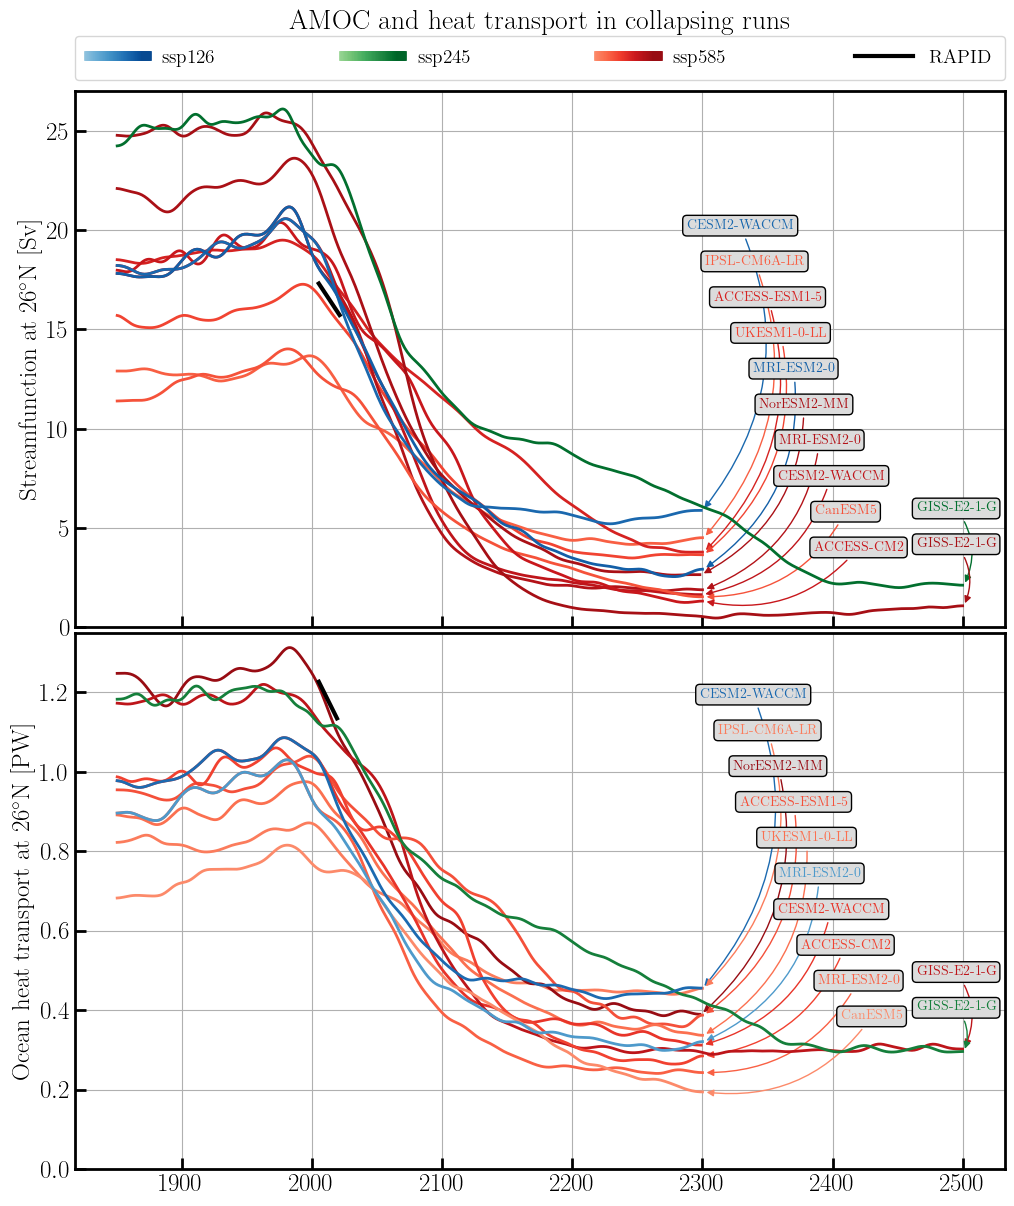

In [31]:
_, axes = plt.subplots(
    2, 1, figsize=(12, 14), sharex=True, gridspec_kw=dict(hspace=0.01)
)
spaghetti_plot(
    axes_dict={k: axes[0] for k in 'ssp126 ssp245 ssp585 GISS-E2-1-G'.split()},
    single_panel=True,
    only_p2300=True,
    split_giss=False,
    all_ensambles=True,
    take_ensemble_mean=True,
    giss_on_seperate_ax=False,
    only_passing=True,
    annotate_below=6,
    passing_reference_value=7,
    annotate_kw=dict(
        size=10,
        use_text_color_for_edge=False,
        use_text_color_for_line=True,
    ),
    **cmap_kw,
    **{
        **kw,
        **dict(
            _ann_dict={
                'dx': 10,
                'dy': 1.8,
                'offy': -0.9,
                'offx': 140,
                'clip_t': 2495,
                'off_for_year': {2500: 4},
            }
        ),
    },
)
add_add_rapid_and_legend(
    rapid_kw, cmap_kw, **oet.utils.legend_kw(ncol=4), axes=[axes[0]]
)
plt.ylim(0, 27)
plt.title('AMOC and heat transport in collapsing runs', y=1.1)

kw_oht = dict(
    rm=rm,
    _ann_dict=dict(
        dx=10, dy=0.09, offy=0.01, offx=150, clip_t=2495, off_for_year={2500: 0.1}
    ),
    **cmap_kw,
    annotate_kw=dict(
        size=10,
        use_text_color_for_edge=False,
        use_text_color_for_line=True,
    ),
    data_from='jenny',
)
rapid_oht_kw = {**rapid_kw, **dict(sel='oht')}

spaghetti_plot(
    axes_dict={k: axes[1] for k in 'ssp126 ssp245 ssp585 GISS-E2-1-G'.split()},
    single_panel=True,
    only_p2300=True,
    split_giss=False,
    all_ensambles=True,
    take_ensemble_mean=True,
    giss_on_seperate_ax=False,
    **kw_oht,
    annotate_below=6,
    passing_reference_value=0.6,
    only_keep_combinations=True,
)
plt.ylim(0, 1.35)
add_add_rapid_and_legend(
    rapid_oht_kw, cmap_kw, **oet.utils.legend_kw(ncol=4), axes=[axes[1]]
)
axes[1].get_legend().remove()
suptitle_and_save('amoc and heat transport', figure='figure_1', skip=True, y=0.93)

/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp126/r1i1p1f1/Omon/msftmz/gr2z/v20200222
/data/volume_2/2024_06_17_msft_manual_stage/data/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Omon/msftmz/gr2z/v20200120


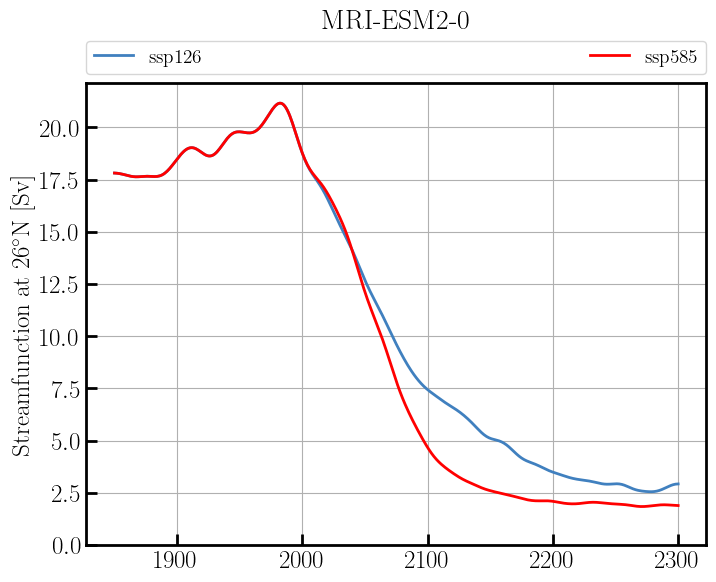

In [32]:
for _, row in df_info[
    (df_info.source_id == 'MRI-ESM2-0')
    & (df_info.last_year == 2300)
    & (df_info.basin == 'atlantic_max')
].iterrows():
    print(row.h)
    ds2, _ = read_from_h(row.h)
    manual_msft.set_time_int(ds2)
    manual_msft.set_depth_meter(ds2)
    plt.plot(
        ds2['time'],
        smoother(ds2['atlantic_max_fix']),
        label=row.ssp,
        c=default_colors[row.ssp],
    )

plt.legend(**oet.utils.legend_kw())
plt.ylim(0, None)
plt.title(row.source_id, y=1.1)
plt.ylabel(f"Streamfunction at 26$^\circ$N [Sv]")
suptitle_and_save('mri streamfunction', figure='figure_s1', skip=True, y=0.93)

read rmx:   0%|          | 0/815 [00:00<?, ?it/s]

plot ts:   0%|          | 0/815 [00:00<?, ?it/s]

('ACCESS-CM2', 'ssp585') kept 10/10
('CanESM5', 'ssp585') kept 50/50
('MRI-ESM2-0', 'ssp585') kept 5/5
('MRI-ESM2-0', 'ssp126') kept 4/4
('ACCESS-ESM1-5', 'ssp585') kept 40/40
('UKESM1-0-LL', 'ssp585') kept 5/5
('IPSL-CM6A-LR', 'ssp585') kept 7/7
('IPSL-CM6A-LR', 'ssp126') kept 6/6
('UKESM1-0-LL', 'ssp126') kept 16/16
('CanESM5', 'ssp126') kept 50/50
('ACCESS-CM2', 'ssp126') kept 10/10
('ACCESS-ESM1-5', 'ssp126') kept 40/40
('GISS-E2-2-G', 'ssp126') kept 5/5
('GISS-E2-2-G', 'ssp245') kept 5/5
('CESM2-WACCM', 'ssp585') kept 5/5
('MIROC-ES2L', 'ssp585') kept 10/10
('CESM2', 'ssp585') kept 3/3
('MIROC-ES2L', 'ssp245') kept 30/30
('CanESM5-1', 'ssp585') kept 18/18
('CanESM5-CanOE', 'ssp585') kept 3/3
('CESM2', 'ssp126') kept 3/3
('MIROC6', 'ssp585') kept 3/3
('MRI-ESM2-0', 'ssp245') kept 4/4
('CESM2-WACCM', 'ssp245') kept 5/5
('MIROC-ES2L', 'ssp126') kept 10/10
('CESM2', 'ssp245') kept 3/3
('HadGEM3-GC31-MM', 'ssp585') kept 4/4
('CNRM-CM6-1', 'ssp585') kept 6/6
('CNRM-ESM2-1', 'ssp585') ke

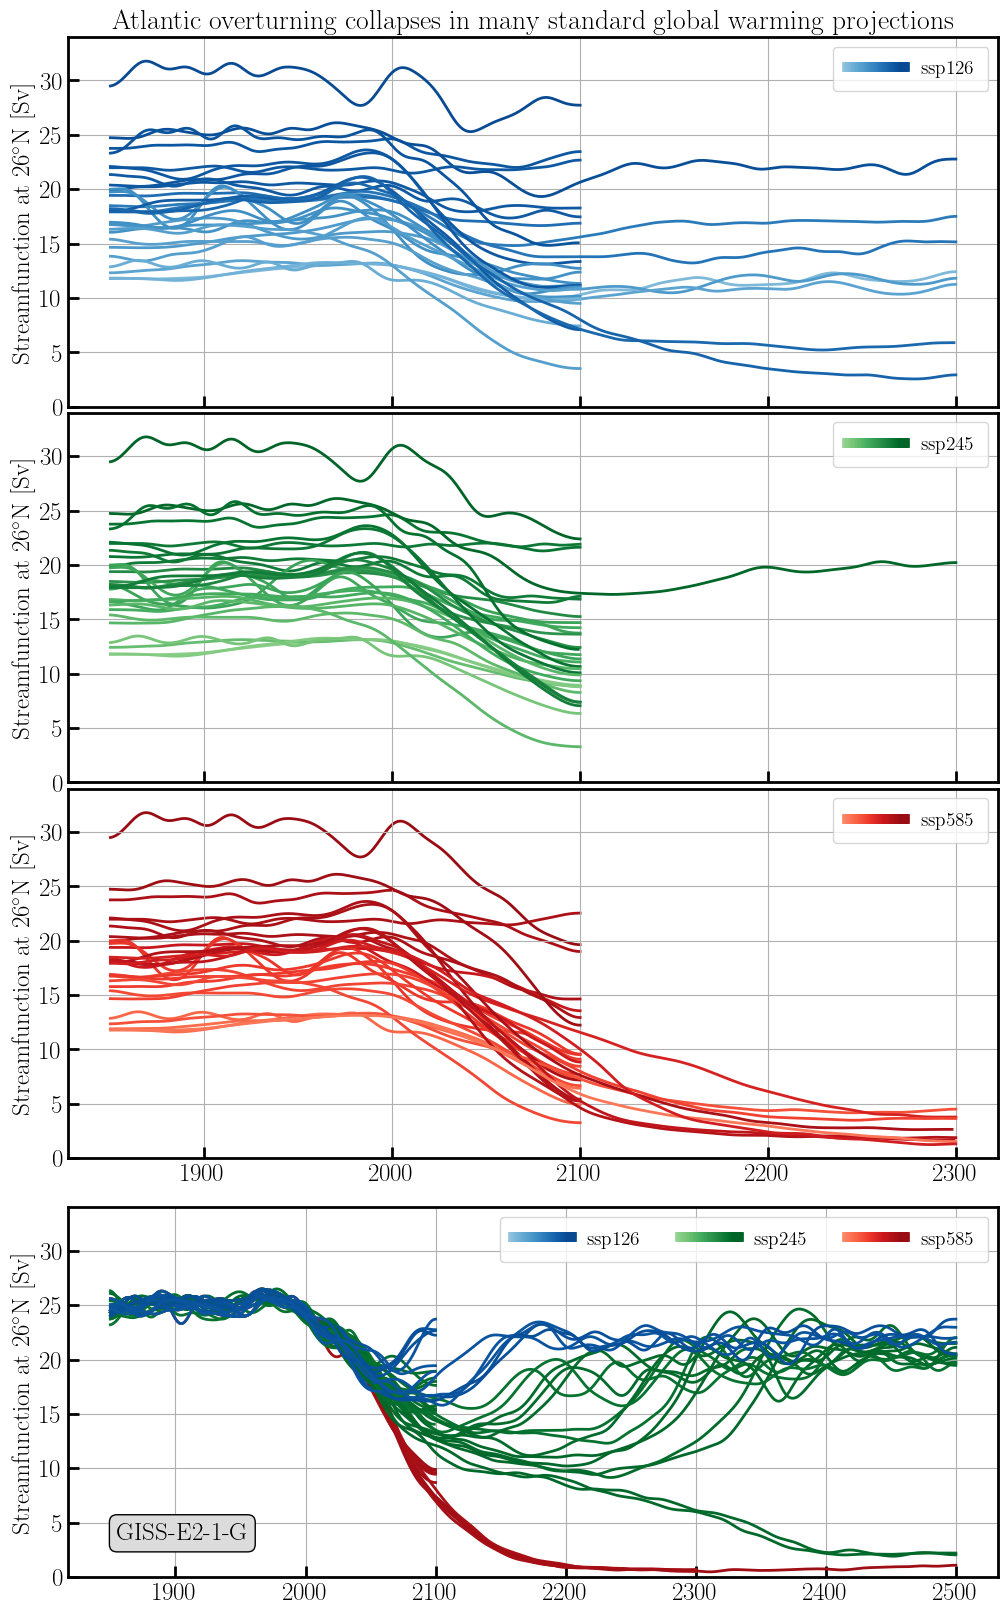

In [33]:
spaghetti_plot(
    single_panel=False,
    only_p2300=False,
    split_giss=False,
    all_ensambles=True,
    take_ensemble_mean=True,
    giss_on_seperate_ax=True,
    include_all_giss_when_seperate=True,
    annotate_below=None,
    **kw,
    **cmap_kw,
)
plt.gcf().axes[0].set_title(
    'Atlantic overturning collapses in many standard global warming projections'
)
# add_add_rapid_and_legend(rapid_kw, cmap_kw)
suptitle_and_save(
    f'All means (except GISS with all ensembles), color-map based on values in 1900-2000, GISS separate (4 panels), rm{rm}',
    figure='figure_s1',
    y=0.85,
    skip=True,
)

plt.show()
#####

## Overview of values in time slices

In [34]:
all_ens = (df_info.basin == "atlantic_max") & (df_info.p_dip < 2)
mask_df = keep_one_per_source_per_ssp_prev_passing

time_slices = [
    slice(1990, 2000),
    slice(2090, 2100),
    slice(2090 + 100, 2100 + 100),
    slice(2090 + 200, 2100 + 200),
    slice(2090 + 300, 2100 + 300),
    slice(2090 + 400, 2100 + 400),
]
slices_dec = [
    (
        f'{row.source_id} {row.ssp} {row.variant_label}',
        row.last_year,
        *[
            read_except_rmx_from_h(row.h, time_slice, rm=1)
            for time_slice in time_slices
        ],
    )
    for __, row in oet.utils.tqdm(list(df_info[mask_df].iterrows()))
]

slices_dec_all = [
    (
        f'{row.source_id} {row.ssp} {row.variant_label}',
        row.last_year,
        *[
            read_except_rmx_from_h(row.h, time_slice, rm=1)
            for time_slice in time_slices
        ],
    )
    for __, row in oet.utils.tqdm(list(df_info[all_ens].iterrows()))
]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/815 [00:00<?, ?it/s]

In [35]:
pd.options.display.max_rows = 120
pd.DataFrame(
    slices_dec,
    columns=['id', 'last_year']
    + [
        manual_msft.slice_to_string(s).replace('$', '').replace(' ', '')
        for s in time_slices
    ],
)

,id,last_year,1990-2000,2090-2100,2190-2200,2290-2300,2390-2400,2490-2500
0,ACCESS-CM2 ssp126 r1i1p1f1,2300,19.183923,13.803646,14.069925,15.172885,NaN,NaN
1,ACCESS-CM2 ssp245 r1i1p1f1,2100,19.184053,12.449775,NaN,NaN,NaN,NaN
2,ACCESS-CM2 ssp585 r1i1p1f1,2300,19.181404,9.942974,2.547671,1.294416,NaN,NaN
3,ACCESS-ESM1-5 ssp126 r1i1p1f1,2300,19.674148,15.551403,17.564933,17.352850,NaN,NaN
4,ACCESS-ESM1-5 ssp245 r1i1p1f1,2100,19.672849,13.822486,NaN,NaN,NaN,NaN
5,ACCESS-ESM1-5 ssp585 r10i1p1f1,2300,18.572107,12.042974,6.216735,3.290885,NaN,NaN
6,CESM2 ssp126 r4i1p1f1,2100,20.480791,6.759824,NaN,NaN,NaN,NaN
7,CESM2 ssp245 r4i1p1f1,2100,20.483783,7.173650,NaN,NaN,NaN,NaN
8,CESM2 ssp370 r4i1p1f1,2100,20.484469,7.598723,NaN,NaN,NaN,NaN
9,CESM2 ssp585 r4i1p1f1,2100,20.482955,5.660115,NaN,NaN,NaN,NaN


In [36]:
df_slices_dec = pd.DataFrame(
    slices_dec,
    columns=['id', 'last_year']
    + [
        manual_msft.slice_to_string(s).replace('$', '').replace(' ', '')
        for s in time_slices
    ],
)
df_slices_dec.to_csv(os.path.join(paper_figure_path, 'strengths_one_member.csv'))
df_slices_dec_all = pd.DataFrame(
    slices_dec_all,
    columns=['id', 'last_year']
    + [
        manual_msft.slice_to_string(s).replace('$', '').replace(' ', '')
        for s in time_slices
    ],
)
df_slices_dec_all.to_csv(os.path.join(paper_figure_path, 'strengths_all_member.csv'))

In [37]:
def perc(x):
    return 100 * sum(x) / len(x)

In [38]:
def simple_hist(
    a,
    scatter=False,
    error_bar=False,
    lines=True,
    hist_kw=None,
    overflow_last=True,
    **plot_kw,
):
    hist_kw = hist_kw or dict()
    c, be = np.histogram(a, **hist_kw)
    bc = (be[1:] + be[:-1]) / 2
    if scatter:
        plt.scatter(bc, c, **plot_kw)
    if error_bar:
        plt.errorbar(bc, c, yerr=np.sqrt(c), **plot_kw)
    if lines:
        plt.plot(bc, c, **plot_kw)
    if overflow_last:
        c[-1] += np.sum(a > be[-1])
    return bc, c

In [39]:
passing = (df_slices_dec['2290-2300'] < 7) & (df_slices_dec['2090-2100'] < 10)

In [40]:
df_slices_dec['ssp'] = [d.split()[1] for d in df_slices_dec['id']]

In [41]:
df_slices_dec[passing]

,id,last_year,1990-2000,2090-2100,2190-2200,2290-2300,2390-2400,2490-2500,ssp
2,ACCESS-CM2 ssp585 r1i1p1f1,2300,19.181404,9.942974,2.547671,1.294416,NaN,NaN,ssp585
12,CESM2-WACCM ssp126 r1i1p1f1,2299,19.838308,7.433291,5.727670,5.880684,NaN,NaN,ssp126
15,CESM2-WACCM ssp585 r1i1p1f1,2299,19.840820,5.953787,2.324884,1.648471,NaN,NaN,ssp585
35,CanESM5 ssp585 r1i1p1f1,2300,13.422693,6.096360,3.060053,1.548227,NaN,NaN,ssp585
59,GISS-E2-1-G ssp585 r5i1p1f2,2300,25.263381,7.750018,1.012670,0.520522,NaN,NaN,ssp585
79,IPSL-CM6A-LR ssp585 r1i1p1f1,2300,13.614843,7.621704,4.422378,4.480439,NaN,NaN,ssp585
91,MRI-ESM2-0 ssp126 r1i1p1f1,2300,19.661899,7.739302,3.616819,2.854180,NaN,NaN,ssp126
93,MRI-ESM2-0 ssp585 r1i1p1f1,2300,19.663872,5.191209,2.112031,1.905977,NaN,NaN,ssp585
99,NorESM2-MM ssp585 r1i1p1f1,2298,23.224933,8.042877,3.357726,2.651821,NaN,NaN,ssp585
102,UKESM1-0-LL ssp585 r4i1p1f2,2300,17.212901,8.416088,3.913486,3.659819,NaN,NaN,ssp585


In [42]:
res_dict = {
    ssp: df_slices_dec[(df_slices_dec['ssp'] == ssp) & (~passing)]['2090-2100'].values
    for ssp in 'ssp126 ssp245 ssp585'.split()
}

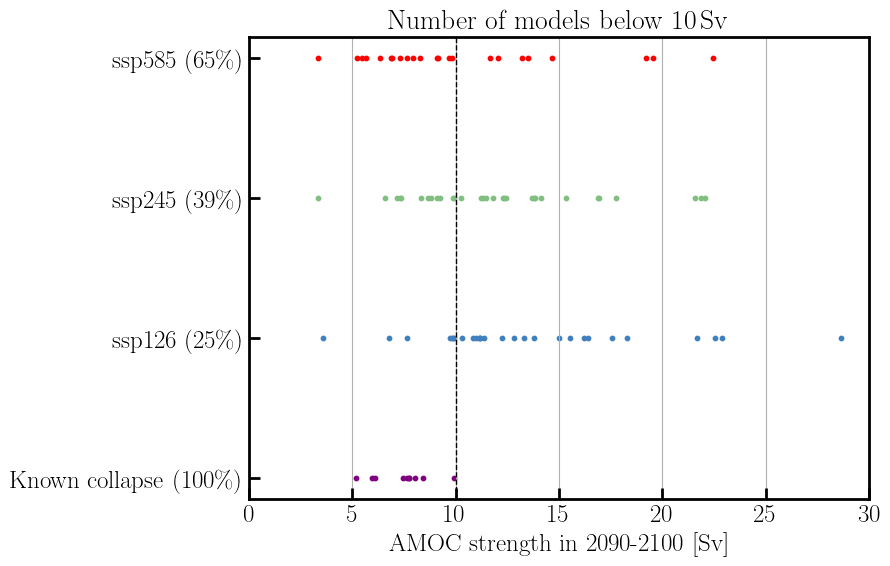

In [43]:
def gauss_1d(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )


plot_kw = dict(s=10)

x = np.linspace(0, 30, 1000)
thrs = 10
a = df_slices_dec[passing]['2090-2100'].values
ticks = np.arange(4)
labels = []
i = 3
plt.scatter(a, [i] * len(a), color='purple', **plot_kw)
labels.append(
    f'Known collapse ({perc(df_slices_dec[passing]["2090-2100"].values<thrs):.0f}$\%$)'
)
for i, (ssp, vv) in enumerate(res_dict.items()):
    j = i + 4
    plt.scatter(vv, [j] * len(vv), color=default_colors[ssp], **plot_kw)
    labels.append(f'{ssp} ({perc(vv<thrs):.0f}$\%$)')

plt.axvline(thrs, ls='--', c='k', lw=1)
plt.title(f'Number of models below {thrs}\,Sv')
plt.xlabel(f'AMOC strength in 2090-2100 [Sv]')
plt.grid(axis='y')
plt.gca().yaxis.set_ticks(ticks + i + 1, labels)
plt.xlim(0, 30)
suptitle_and_save(
    f'Number of models below {thrs}\,Sv', skip=True, figure='figure_s7', y=0.93
)

## Depth discussion

In [44]:
def get_max_at_time_series(
    ds,
    sel_sector='atlantic',
    variable_id=None,
    meter_min=800,
    lat_min=None,
    lat_sel=None,
):
    variable_id = variable_id or ds.variable_id
    ds = ds.copy()
    b_var = manual_msft.get_basin_var(ds)
    sectors = [manual_msft.sector_normalize(s) for s in manual_msft.get_sectors(ds)]
    manual_msft.set_depth_meter(ds)

    assert len(ds[b_var]) == len(sectors)

    for s_i, sector in enumerate(sectors):
        if sector != sel_sector:
            continue
        da_sel = ds[variable_id].isel(**{b_var: s_i})
        if lat_min is not None:
            da_sel = da_sel.where(
                ds[manual_msft.get_rlat_coord(ds)] > lat_min, drop=True
            )
        if lat_sel is not None:
            da_sel = da_sel.sel(
                **{manual_msft.get_rlat_coord(ds): lat_sel}, method='nearest'
            )
        if meter_min is not None:
            da_sel = da_sel.where(
                ds[manual_msft.get_lev_coord(ds)] > meter_min, drop=False
            )
        return da_sel

In [45]:
def get_ds_in_sector(ds, sel_sector='atlantic'):
    b_var = manual_msft.get_basin_var(ds)
    sectors = [manual_msft.sector_normalize(s) for s in manual_msft.get_sectors(ds)]

    assert len(ds[b_var]) == len(sectors)

    for s_i, sector in enumerate(sectors):
        if sector != sel_sector:
            continue
        return ds.isel(**{b_var: s_i})

In [46]:
def get_ts(ds2):
    da_north_500 = get_max_at_time_series(ds2, lat_min=0, meter_min=500)
    _, max_2d_north_500 = manual_msft.min_max_lat_lev_idx(da_north_500.values.squeeze())
    ts_north_500 = manual_msft.index_2d(da_north_500.values.squeeze(), max_2d_north_500)

    da_26p5N_500 = get_max_at_time_series(ds2, lat_sel=26.5, meter_min=500)
    v_i = da_26p5N_500.values.squeeze()
    len_time, len_lev = v_i.shape
    v_i = v_i.reshape(len_time, len_lev, 1)
    _, max_2d_26p5N_500 = manual_msft.min_max_lat_lev_idx(v_i)
    ts_26p5N_500 = manual_msft.index_2d(v_i, max_2d_26p5N_500)

    return ts_north_500, ts_26p5N_500

In [47]:
df_info[(df_info['pass']) & (df_info['ssp'] == 'ssp585')][_header]

,source_id,last_year,variant_label,variable_id,ssp
3815,ACCESS-CM2,2300,r1i1p1f1,msftmz,ssp585
3929,ACCESS-ESM1-5,2300,r1i1p1f1,msftmz,ssp585
3995,ACCESS-ESM1-5,2300,r2i1p1f1,msftmz,ssp585
4061,ACCESS-ESM1-5,2300,r3i1p1f1,msftmz,ssp585
4073,ACCESS-ESM1-5,2300,r4i1p1f1,msftmz,ssp585
4079,ACCESS-ESM1-5,2300,r5i1p1f1,msftmz,ssp585
4085,ACCESS-ESM1-5,2300,r6i1p1f1,msftmz,ssp585
4091,ACCESS-ESM1-5,2300,r7i1p1f1,msftmz,ssp585
4097,ACCESS-ESM1-5,2300,r8i1p1f1,msftmz,ssp585
4103,ACCESS-ESM1-5,2300,r9i1p1f1,msftmz,ssp585


In [48]:
means = dict(
    ts_north_500=defaultdict(list),
    ts_26p5N_500=defaultdict(list),
    ts_fix=defaultdict(list),
)
depths = defaultdict(list)
for _, row in oet.utils.tqdm(
    list(df_info[(df_info['pass']) & (df_info['ssp'] == 'ssp585')].iterrows())
):
    ds2, _ = read_from_h(row.h)
    ds2 = ds2.sel(time=slice(None, 2298))
    depths[row.source_id].append(manual_msft.get_depth(ds2))
    manual_msft.set_time_int(ds2)
    manual_msft.set_depth_meter(ds2)
    ts_north_500, ts_26p5N_500 = get_ts(ds2)
    ts_fix = ds2['atlantic_max_fix'].values

    means['ts_north_500'][row.source_id].append(ts_north_500)
    means['ts_26p5N_500'][row.source_id].append(ts_26p5N_500)
    means['ts_fix'][row.source_id].append(ts_fix)

  0%|          | 0/22 [00:00<?, ?it/s]

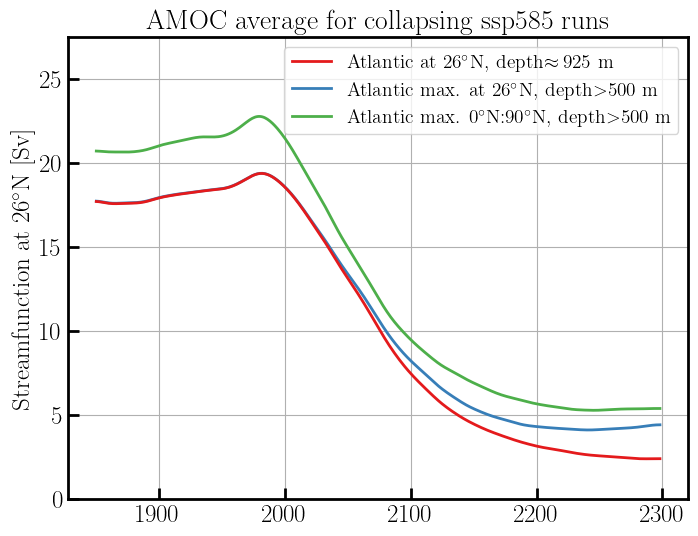

In [49]:
labels = dict(
    ts_north_500=f'Atlantic max. 0$^\circ$N:90$^\circ$N, depth$>${500} m',
    ts_26p5N_500=f'Atlantic max. at 26$^\circ$N, depth$>$500 m',
    ts_fix=f'Atlantic at 26$^\circ$N, depth$\\approx{np.mean([np.mean(d) for d in depths.values()]):.0f}$ m',
)
for i, k in enumerate(['ts_fix', 'ts_26p5N_500', 'ts_north_500']):
    mm = np.nanmean([np.nanmean(m, axis=0) for m in means[k].values()], axis=0)

    plt.plot(ds2['time'], smoother(mm), label=labels[k], zorder=3 - i / 3)
plt.title('AMOC average for collapsing ssp585 runs')
plt.legend()
plt.ylim(0, 27.5)
plt.ylabel(f"Streamfunction at 26$^\circ$N [Sv]")
oet.utils.save_fig(
    'amoc average',
    save_in=paper_figure_path,
    sub_dir='figure_s5',
    file_types=('png',),
    dpi=300,
)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

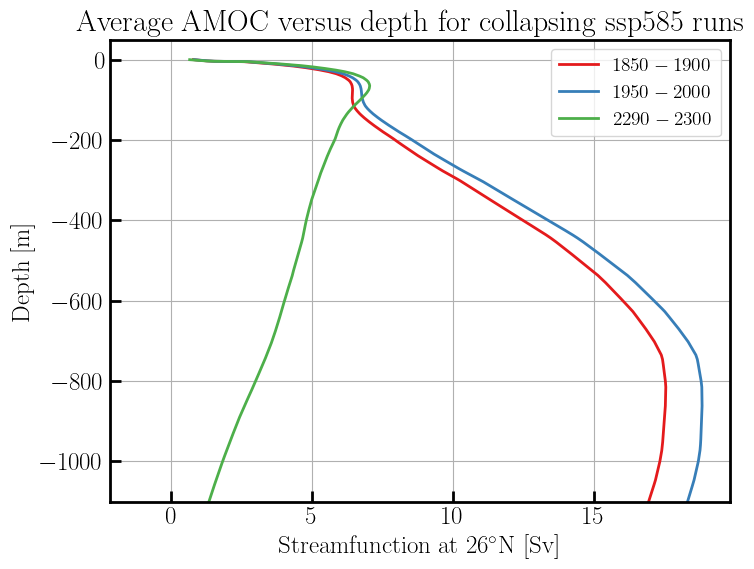

In [50]:
years = slice(2290, 2300)
grid = np.arange(0, 5001, 1)


def mean_sl(sl):
    return (sl.stop + sl.start) / 2


for years in [slice(1850, 1900), slice(1950, 2000), slice(2290, 2300)]:
    means_depth = defaultdict(list)
    for _, row in oet.utils.tqdm(
        list(df_info[(df_info['pass']) & (df_info['ssp'] == 'ssp585')].iterrows())
    ):
        h = row.h
        ds2, _ = read_from_h(h)

        ds2 = get_ds_in_sector(ds2)
        manual_msft.set_time_int(ds2)
        manual_msft.set_depth_meter(ds2)
        try:
            da = (
                ds2[ds2.variable_id]
                .sel(time=years)
                .sel({manual_msft.get_rlat_coord(ds2): 26.5}, method='nearest')
                .mean('time')
            )
        except KeyError:
            raise
        itp = scipy.interpolate.interp1d(
            da[manual_msft.get_lev_coord(ds2)],
            da.values.squeeze(),
            bounds_error=False,
            fill_value=0,
        )
        v = itp(grid)
        if np.any(np.isnan(v)):
            continue
        means_depth[ds2.source_id] += [v]

    plt.plot(
        np.nanmean([np.nanmean(v, axis=0) for v in means_depth.values()], axis=0),
        -grid,
        label=manual_msft.slice_to_string(years),
    )

plt.suptitle(f'Average AMOC versus depth for collapsing ssp585 runs', y=0.93)
plt.legend()
# oet.utils.save_fig(f'depth profiles',
#                        save_in=os.path.join(os.path.split(main_fig_folder)[0], 'figure_s1'),
#                        sub_dir='', file_types=('png',), dpi=150)
plt.ylim(-1100, 50)
# plt.xlim(0, 18)
plt.ylabel('Depth [m]')
plt.xlabel(f"Streamfunction at 26$^\circ$N [Sv]")
oet.utils.save_fig(
    'average amoc depth',
    save_in=paper_figure_path,
    sub_dir='figure_s5',
    file_types=('png',),
    dpi=300,
)
plt.show()

In [51]:
years = slice(2290, 2300)
grid = np.arange(0, 5001, 1)


def mean_sl(sl):
    return (sl.stop + sl.start) / 2


means = defaultdict(list)
for years in [slice(1850, 1900), slice(1950, 2000)]:

    for _, row in oet.utils.tqdm(
        list(df_info[(df_info['pass']) & (df_info['ssp'] == 'ssp585')].iterrows())
    ):
        h = row.h
        ds2, _ = read_from_h(h)

        ds2 = get_ds_in_sector(ds2)
        manual_msft.set_time_int(ds2)
        manual_msft.set_depth_meter(ds2)
        da = (
            ds2[ds2.variable_id]
            .sel(time=years)
            .sel({manual_msft.get_rlat_coord(ds2): 26.5}, method='nearest')
            .mean('time')
        )
        idx = np.nanargmax(da.values)
        d = ds2[manual_msft.get_lev_coord(ds2)].values[idx]
        if d > 1500:
            raise
        means[h].append(d)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

# Crosssections

In [52]:
x = []
ds_dict = dict()
seen = []
for _, row in oet.utils.tqdm(list(df_info[df_info['pass']].iterrows())):

    if row.ssp not in ds_dict:
        ds_dict[row.ssp] = defaultdict(list)
    ds2, _ = read_from_h(row.h)
    manual_msft.set_depth_meter(ds2)
    if row.last_year > 2200:
        ds_dict[row.ssp][row.source_id].append(ds2)

  0%|          | 0/26 [00:00<?, ?it/s]

In [53]:
ds_dict_new = defaultdict(list)
for ssp in list(ds_dict):
    for model in list(ds_dict[ssp]):
        if len(ds_dict[ssp][model]) > 1:
            print(ssp, model)
            average_ds = (sum(ds_dict[ssp][model]) / len(ds_dict[ssp][model])).compute()

            if not average_ds.attrs:
                average_ds.attrs = ds_dict[ssp][model][0].attrs.copy()
            ds_dict_new[ssp].append(average_ds)
        else:
            ds_dict_new[ssp].append(ds_dict[ssp][model][0])

ssp585 ACCESS-ESM1-5
ssp585 GISS-E2-1-G
ssp245 GISS-E2-1-G


In [54]:
kw = dict(
    lat_grid=np.linspace(-32, 85, 1000),
    lev_grid=np.linspace(-5000, 0, 1000),
)
ensambles = {
    ssp: manual_msft.EnsambleFromYear(ds_s, **kw) for ssp, ds_s in ds_dict_new.items()
}
skw = dict(
    ha='right',
    va='bottom',
    bbox=dict(facecolor='gainsboro', edgecolor='black', boxstyle='round'),
)


0 ssp585 slice(1990, 2000, None)
1 ssp126 slice(1990, 2000, None)


/tmp/ipykernel_1250309/1098556826.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for _ in ax.get_yticklabels()])


2 ssp245 slice(1990, 2000, None)
3 ssp585 slice(2090, 2100, None)
4 ssp126 slice(2090, 2100, None)


/tmp/ipykernel_1250309/1098556826.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for _ in ax.get_yticklabels()])


5 ssp245 slice(2090, 2100, None)
6 ssp585 slice(2290, 2300, None)
7 ssp126 slice(2290, 2300, None)


/tmp/ipykernel_1250309/1098556826.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for _ in ax.get_yticklabels()])


8 ssp245 slice(2390, 2400, None)


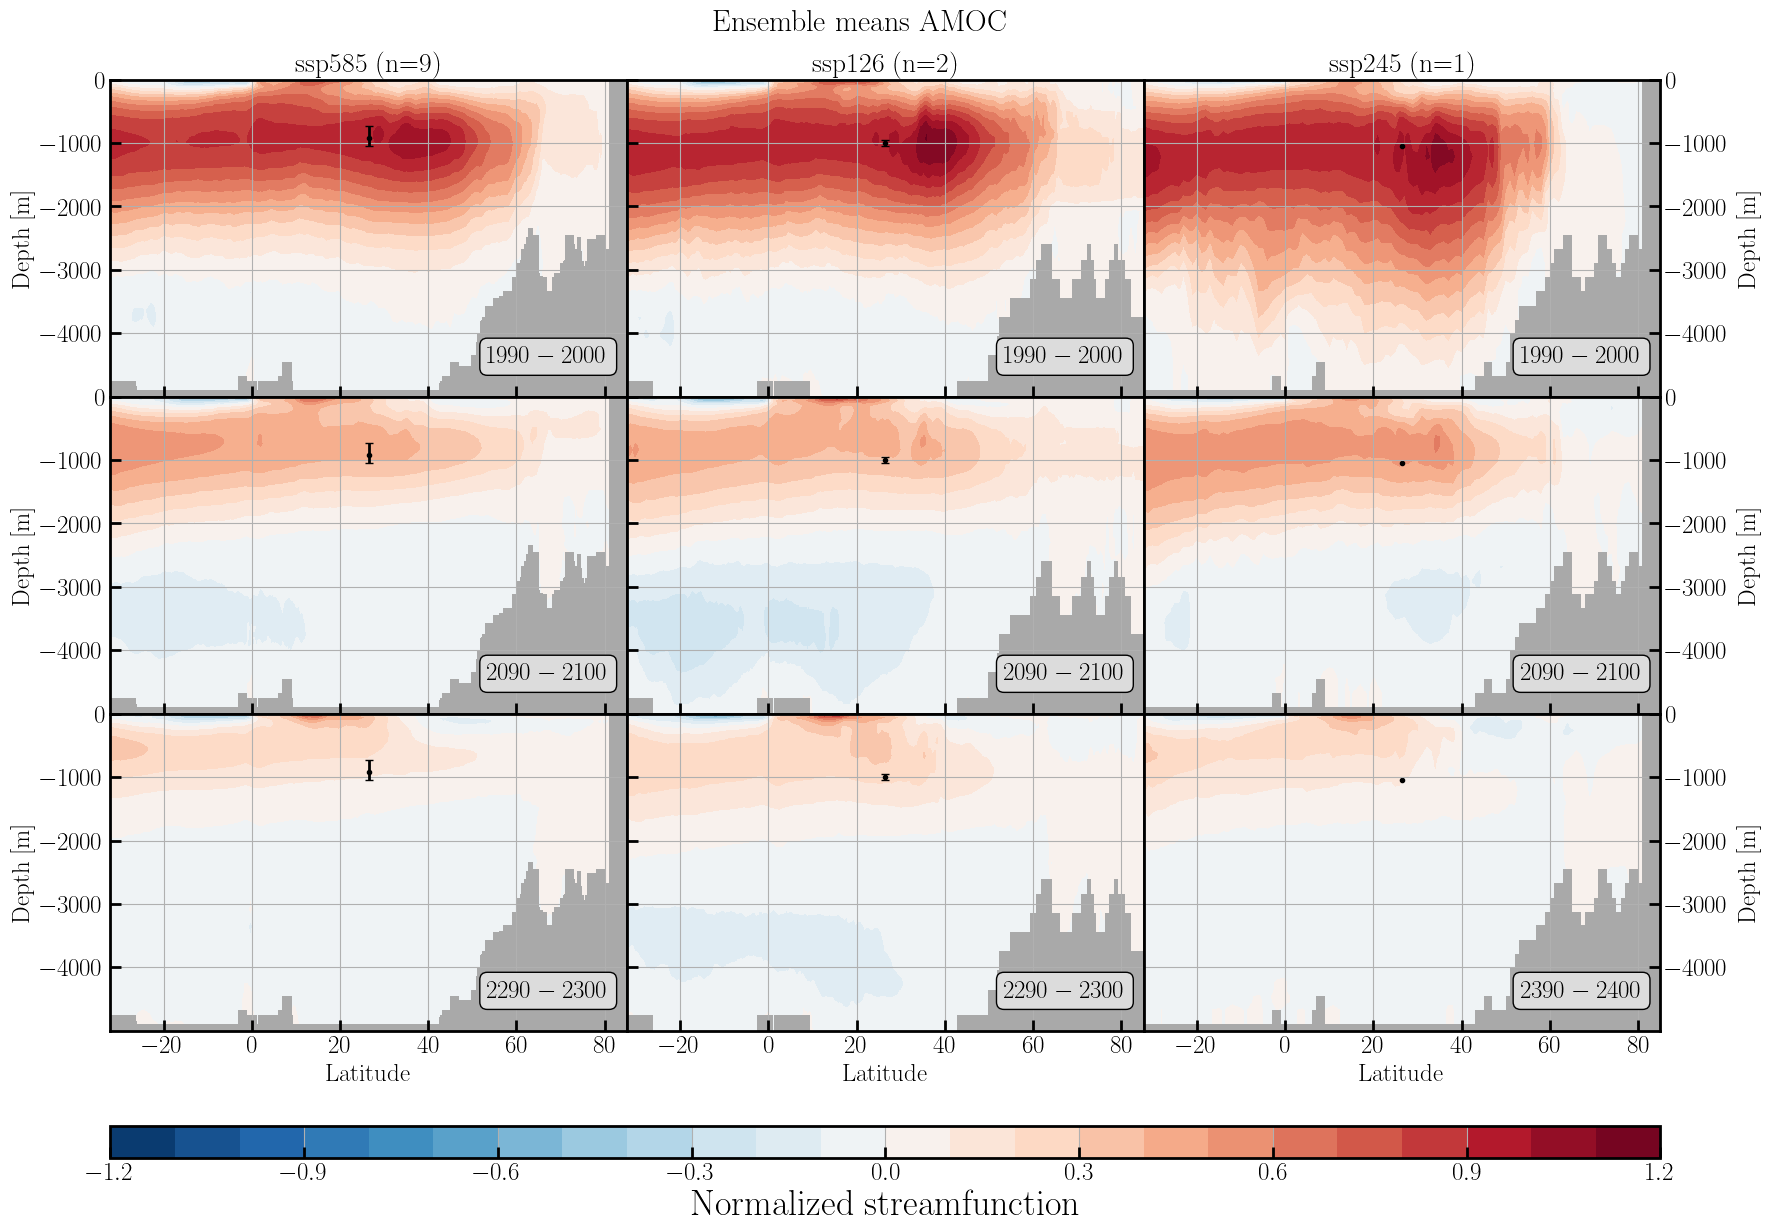

In [55]:
fig, axes = plt.subplot_mosaic(
    'abc\ndef\nghi\n...\nkkk',
    figsize=(20, 14),
    gridspec_kw=dict(height_ratios=[1, 1, 1, 0.3, 0.1], hspace=0.0, wspace=0.0),
)

iter_axes = iter([ax for k, ax in axes.items() if k not in 'jk'])

reference = dict()


p_kw = dict(
    vmin=-1.2,
    vmax=1.2,
    extend='both',
    cmap='RdBu_r',
    add_colorbar=False,
    levels=np.linspace(-1.2, 1.2, 25, endpoint=True),
)

for i, (year, ssp) in enumerate(
    itertools.product(
        [
            slice(1990, 2000),
            slice(2090, 2100),
            slice(2290, 2300),
        ],
        'ssp585 ssp126 ssp245'.split(),
    )
):
    if ssp == 'ssp245' and year == slice(2290, 2300):
        year = slice(2390, 2400)
    print(i, ssp, year)
    ens = ensambles[ssp]
    tot = ens.ensamble_from_year(
        year_slice=year, normalize_to_year=slice(1990, 2000)
    ).astype(np.float64)
    ax = next(iter_axes)

    tot.plot(ax=ax, **p_kw)
    ax.set_facecolor('darkgray')

    if i < 3:
        ax.set_title(f'{ssp} (n={len(ds_dict[ssp])})')
    if i in range(0, 10, 3):
        ax.set_ylabel('Depth [m]')
    elif i in range(1, 10, 3):
        ax.set_ylabel('')
        ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
    else:
        ax.set_ylabel('Depth [m]')
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    ax.set_xlabel('Latitude' if i > 5 else '')

    ax.text(
        ax.get_xlim()[1] / 1.05,
        ax.get_ylim()[0] / 1.1,
        manual_msft.slice_to_string(year),
        **skw,
    )
    ax.grid()
    majors = [0, -1000, -2000, -3000, -4000]
    minors = [-1000, -3000]
    ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))

    if tot.sum():
        depths = -np.array([manual_msft.get_depth(ds_n) for ds_n in ens.ds_group])
        md = np.mean(depths)
        if np.std(depths):
            ax.errorbar(
                [26.5],
                [md],
                c='black',
                marker='.',
                yerr=np.array(
                    [[np.abs(np.min(depths) - md)], [np.abs(np.max(depths) - md)]]
                ),
                capsize=3,
            )
        else:
            ax.scatter(
                [26.5],
                [md],
                c='black',
                marker='.',
            )
plt.suptitle('Ensemble means AMOC', y=0.93)

cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=p_kw['vmin'], vmax=p_kw['vmax'])

cb1 = mpl.colorbar.ColorbarBase(
    axes['k'],
    cmap=cmap,
    norm=norm,
    orientation='horizontal',
    boundaries=p_kw['levels'],
)

cb1.set_label(
    '$\Psi(t = {1990 - 2000})=\\frac{\\mathrm{Stream\ function}(t = {1990 - 2000},\ \\mathrm{lat},\ \\mathrm{depth}))}'
    '{\\mathrm{Stream\ function }(t={1990 - 2000},\ \\mathrm{lat}=26.5\,^\\circ\\mathrm{N},\ \\mathrm{depth}\\sim-1000\,\\mathrm{m})}$',
    fontsize='x-large',
)
cb1.set_label('Normalized streamfunction')

oet.utils.save_fig(
    save_in=os.path.join(paper_figure_path, 'figure_s2'),
    file_types=('png',),
    sub_dir='',
    name='ensemble_streamfunction_cross_sections_3x3',
    dpi=300,
)
plt.show()